In [1]:
# !pip uninstall umap --yes
# !pip uninstall umap-learn --yes
# !pip3 install umap-learn
# !conda uninstall umap-learn
# !pip freeze
# !conda install -y -c conda-forge umap-learn --force-reinstall

In [ ]:
### Import personal libraries

import importlib.util
import glob
from pathlib import Path
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy.stats
from kymatio import Scattering2D
import json
import numpy as np
import torchvision
import torch
from tqdm.notebook import tqdm, trange
import sklearn
from sklearn.model_selection import train_test_split
import sys

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# sys.path.append(params['paths']['dir_github'])
sys.path.append('/Users/josh/Documents/github_repos')
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition, path_helpers
from GCaMP_ROI_classifier import util, models, training, augmentation, dataset

In [21]:
# base_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/20220510_testingSimCLRscript/jobNum_*/'
# base_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp'
base_dir = '/Users/josh/Documents/analysis/analysis/ROI_net_training/simCLR_paramsweep_temp'

jns = sorted(glob.glob(str(Path(base_dir) / 'jobNum_*')))

In [3]:
pth_fn_lst = []
log_fn_lst = []
loss_fn_lst = []
params_fn_lst = []
run_outputs_fn_lst = []
sbatch_config_fn_lst = []
base_py_fn_lst = []

params_lst = []
run_outputs_lst = []

for jn in jns:
    print(jn)
    
    pth_fn = glob.glob(str(Path(jn) / '*.pth'))
    log_fn = glob.glob(str(Path(jn) / 'log.txt'))
    loss_fn = glob.glob(str(Path(jn) / 'loss.npy'))
    params_fn = glob.glob(str(Path(jn) / 'params.json'))
    run_outputs_fn = glob.glob(str(Path(jn) / 'run_outputs.json'))
    sbatch_config_fn = glob.glob(str(Path(jn) / 'sbatch_config.sh'))
    base_py_fn = glob.glob(str(Path(jn) / '*.py'))
    
    assert len(pth_fn) == 1
    assert len(log_fn) == 1
    assert len(loss_fn) == 1
    assert len(params_fn) == 1
    assert len(run_outputs_fn) == 1
    assert len(sbatch_config_fn) == 1
    assert len(base_py_fn) == 1
    
    
    with open(params_fn[0], 'rb') as f:
        params_lst += [json.load(f)]
        
    with open(run_outputs_fn[0], 'rb') as f:
        run_outputs_lst += [json.load(f)]
    
    pth_fn_lst += pth_fn
    log_fn_lst += log_fn
    loss_fn_lst += loss_fn
    params_fn_lst += params_fn
    run_outputs_fn_lst += run_outputs_fn
    sbatch_config_fn_lst += sbatch_config_fn
    base_py_fn_lst += base_py_fn
    
    

/Users/josh/Documents/analysis/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_0
/Users/josh/Documents/analysis/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_1
/Users/josh/Documents/analysis/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_2


In [4]:
params = params_lst[0]
run_outputs = run_outputs_lst[0]

In [6]:
spec = importlib.util.spec_from_file_location(base_py_fn_lst[0].split('/')[-1][:-3], base_py_fn_lst[0])
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

# module.ModelTackOn()

# model = module.ModelTackOn(
#     #     model_chopped.to('cpu'),
#         model_chopped_pooled.to('cpu'),
#         base_model_frozen.to('cpu'),
#         data_dim=data_dim,
#         pre_head_fc_sizes=params['pre_head_fc_sizes'], 
#         post_head_fc_sizes=params['post_head_fc_sizes'], 
#         classifier_fc_sizes=None,
#         nonlinearity=params['head_nonlinearity'],
#         kwargs_nonlinearity={},
#     )

sys.version_info(major=3, minor=8, micro=12, releaselevel='final', serial=0)
ROI_env


In [ ]:
# image_out_size = list(dataset[0][0][0].shape)

def model_from_params(params, ModelTackOn, image_out_size=[3, 224, 224], pref_log_all_steps=False):
    base_model_frozen = torchvision.models.__dict__[params['torchvision_model']](pretrained=True)
    for param in base_model_frozen.parameters():
        param.requires_grad = False
    if pref_log_all_steps:
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}  imported pretrained model')

    ### Make combined model

    ## Tacking on the latent layers needs to be done in a few steps.

    ## 0. Chop the base model
    ## 1. Tack on a pooling layer to reduce the size of the convlutional parameters
    ## 2. Determine the size of the output (internally done in ModelTackOn)
    ## 3. Tack on a linear layer of the correct size  (internally done in ModelTackOn)

    if pref_log_all_steps:
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}  making combined model...')

    model_chopped = torch.nn.Sequential(list(base_model_frozen.children())[0][:params['n_block_toInclude']])  ## 0.
    model_chopped_pooled = torch.nn.Sequential(model_chopped, torch.nn.AdaptiveAvgPool2d(output_size=1), torch.nn.Flatten())  ## 1.
    
    data_dim = tuple([1] + list(image_out_size))
    
    model = ModelTackOn(
    #     model_chopped.to('cpu'),
        model_chopped_pooled.to('cpu'),
        base_model_frozen.to('cpu'),
        data_dim=data_dim,
        pre_head_fc_sizes=params['pre_head_fc_sizes'], 
        post_head_fc_sizes=params['post_head_fc_sizes'], 
        classifier_fc_sizes=None,
        nonlinearity=params['head_nonlinearity'],
        kwargs_nonlinearity={},
    )
    return base_model_frozen, model_chopped, model_chopped_pooled, image_out_size, data_dim, model

def helper_make_dataset(X):
    out = dataset.dataset_simCLR(
        X=torch.as_tensor(X, device='cpu', dtype=torch.float32),
        y=torch.as_tensor(torch.zeros(X.shape[0]), device='cpu', dtype=torch.float32),
        n_transforms=1,
        class_weights=np.array([1]),
        transform=scripted_transforms_classifier,
        DEVICE='cpu',
        dtype_X=torch.float32,
    )
    return out

def helper_make_dataloader(ds):
    out = torch.utils.data.DataLoader( 
        ds,
        batch_size=128,
        shuffle=False,
        drop_last=False
    )
    return out

def get_balanced_sample_weights(labels):
    labels = np.int64(labels.copy())
    counts, vals = np.histogram(labels, bins=np.concatenate((np.unique(labels), [labels.max()+1])))
    vals = vals[:-1]

    n_labels = len(labels)
    weights = n_labels / counts
    
    sample_weights = np.array([weights[l] for l in labels])
    
    return sample_weights

def get_latents_swt(sfs, swt, device_model):
    sfs = torch.as_tensor(np.ascontiguousarray(sfs[None,...]), device=device_model, dtype=torch.float32)
    latents_swt = swt(sfs[None,...]).squeeze()
    latents_swt = latents_swt.reshape(latents_swt.shape[0], -1)
    return latents_swt


In [7]:
(base_model_frozen, model_chopped, model_chopped_pooled,
image_out_size, data_dim, model) = model_from_params(params,
                                                     module.ModelTackOn,
                                                     image_out_size=run_outputs['image_resized_shape'],
                                                     pref_log_all_steps=False)


In [8]:
### unfreeze particular blocks in model

mnp = [name for name, param in model.named_parameters()]  ## 'model named parameters'
mnp_blockNums = [name[name.find('.'):name.find('.')+8] for name in mnp]  ## pulls out the numbers just after the model name
mnp_nums = [path_helpers.get_nums_from_string(name) for name in mnp_blockNums]  ## converts them to numbers
block_to_freeze_nums = path_helpers.get_nums_from_string(params['block_to_unfreeze'])  ## converts the input parameter specifying the block to freeze into a number for comparison

m_baseName = mnp[0][:mnp[0].find('.')]

for ii, (name, param) in enumerate(model.named_parameters()):
    if m_baseName in name:
#         print(name)
        if mnp_nums[ii] < block_to_freeze_nums:
            param.requires_grad = False
        elif mnp_nums[ii] >= block_to_freeze_nums:
            param.requires_grad = True

names_layers_requiresGrad = [( param.requires_grad , name ) for name,param in list(model.named_parameters())]

In [9]:
# ### Training

# model.to(device_train)
# model.prep_contrast()
model.forward = model.forward_latent

<IPython.core.display.Javascript object>


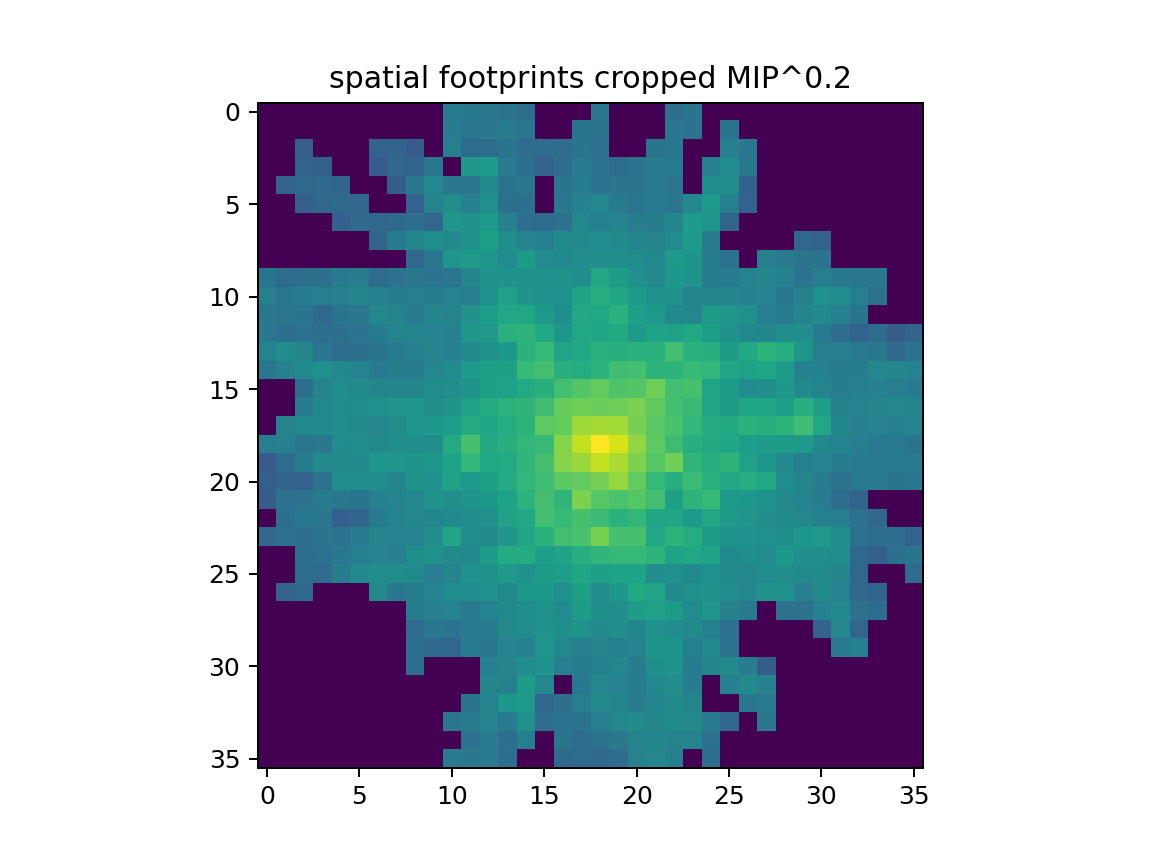

device: 'cpu'


In [14]:
# path_stat = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/stat.npy'
# path_labels = [r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy', '/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy']

# # path_stat = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse6_28 _ day20200815/stat.npy'
# # path_labels = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse6_28 _ day20200815/labels_posthoc_all.npy'

path_stat = r'/Users/josh/Documents/github_repos/GCaMP_ROI_classifier_reorg/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy'
path_labels = [r'/Users/josh/Documents/github_repos/GCaMP_ROI_classifier_reorg/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh1.npy',
               r'/Users/josh/Documents/github_repos/GCaMP_ROI_classifier_reorg/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh2.npy']


images_labeled = np.concatenate(
    util.import_multiple_stat_files(   
        paths_statFiles=[path_stat],
        out_height_width=[36,36],
        max_footprint_width=241,
        plot_pref=True
    )
)

# labels = classification.squeeze_integers(np.concatenate([np.load(path_labels)]))

labels = classification.squeeze_integers(np.concatenate([np.load(path) for path in path_labels]))
images_labeled = np.concatenate((images_labeled, images_labeled), axis=0)

assert images_labeled.shape[0] == labels.shape[0] , 'num images in stat files does not correspond to num labels'

# ### Define augmentation pipeline

# aug_params = {
#     'Scale_image_sum': params['augmentation']['Scale_image_sum'],
#     'ScaleDynamicRange': params['augmentation']['ScaleDynamicRange'],
#     'TileChannels': params['augmentation']['TileChannels'],
# }
# transforms_classifier = torch.nn.Sequential(
# #     *[augmentation.__dict__[key](**params) for key,params in params['augmentation'].items()]
#     *[augmentation.__dict__[key](**params) for key,params in aug_params.items()]
# )

transforms_classifier = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(
        size=(224, 224),   
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)

scripted_transforms_classifier = torch.jit.script(transforms_classifier)

device_dataloader = torch_helpers.set_device(use_GPU=params['useGPU_dataloader'])


In [15]:
idx_toKeep = np.where(np.logical_not(labels == 4))[0]

images_labeled_clean = images_labeled[idx_toKeep]
labels_clean = labels[idx_toKeep]

In [16]:
dataset_labeled_clean = helper_make_dataset(images_labeled_clean)
dataloader_labeled_clean = helper_make_dataloader(dataset_labeled_clean)
DEVICE = torch_helpers.set_device(use_GPU=params['useGPU_dataloader'])

device: 'cpu'


In [22]:
model.eval()
model.to(DEVICE)
features_nn = torch.cat([model.base_model(data[0][0].to(DEVICE)).detach().cpu() for data in tqdm(dataloader_labeled_clean)], dim=0)

  0%|          | 0/76 [00:00<?, ?it/s]

In [25]:
device_model = torch_helpers.set_device(use_GPU=True)

scattering = Scattering2D(J=2, L=8, shape=images_labeled_clean[0].shape[-2:])
if device_model != 'cpu':
    scattering = scattering.cuda()

latents_swt = get_latents_swt(images_labeled_clean, scattering.to(device_model), device_model).cpu()

no GPU available. Using CPU.


/Users/josh/opt/anaconda3/envs/ROI_env/lib/python3.8/site-packages/kymatio/frontend/entry.py:20: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  warnings.warn("Torch frontend is currently the default, but NumPy will become the default in the next"


In [26]:
torch.corrcoef(features_nn.T).shape

torch.Size([768, 768])

<IPython.core.display.Javascript object>


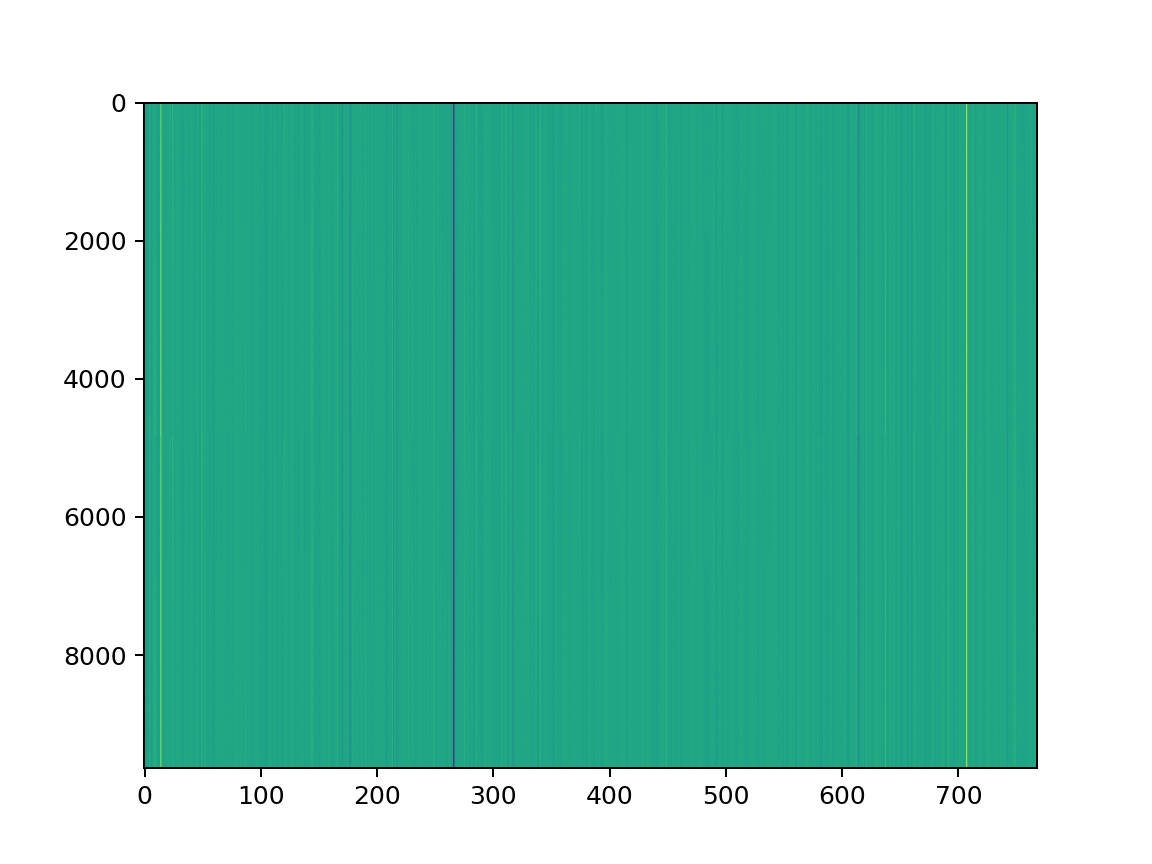

In [43]:
plt.figure()
plt.imshow(features_nn, aspect='auto',)

<IPython.core.display.Javascript object>


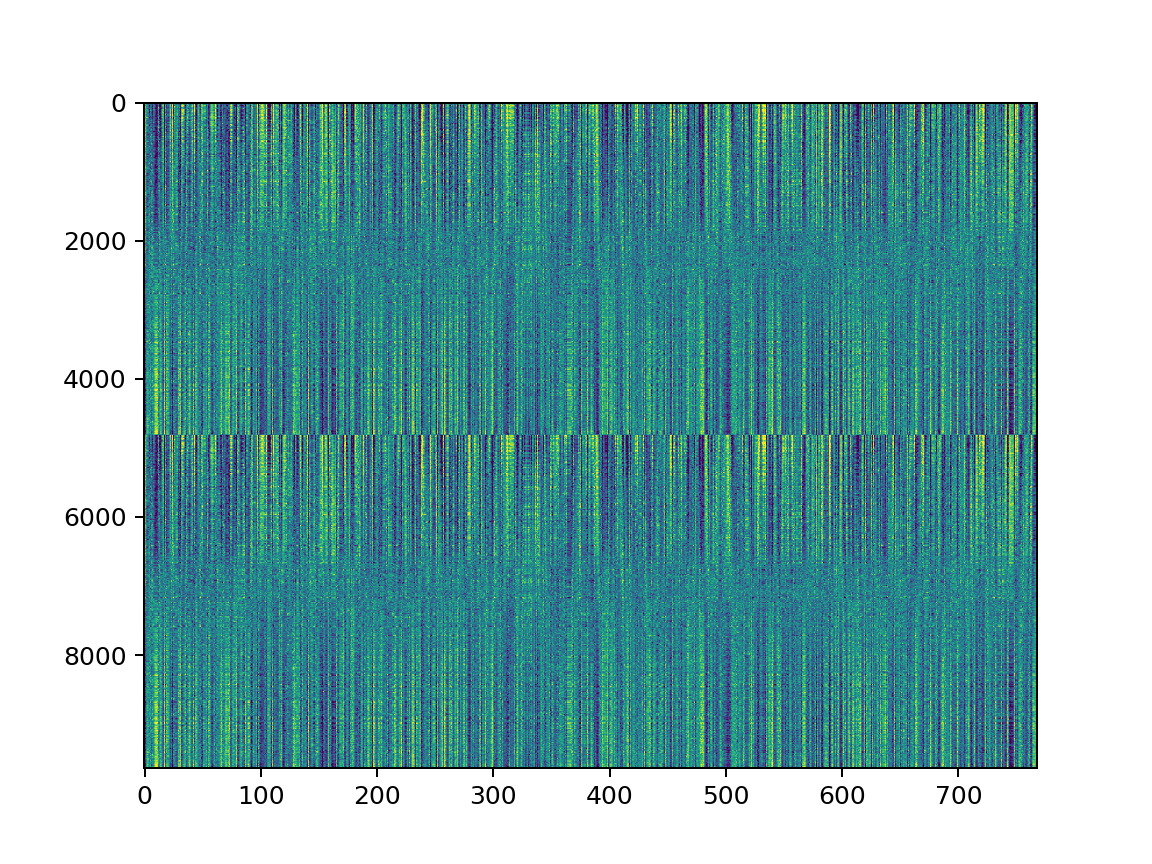

/Users/josh/opt/anaconda3/envs/ROI_env/lib/python3.8/site-packages/scipy/stats/stats.py:2555: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_numpy.cpp:178.)
  z[np.broadcast_to(isconst, z.shape)] = np.nan


In [28]:
plt.figure()
plt.imshow(scipy.stats.zscore(features_nn, axis=0), aspect='auto', vmin=-0.8, vmax=1,)

In [29]:
features_nn_z = scipy.stats.zscore(features_nn.numpy(), axis=0)
features_nn_z = features_nn_z[:, ~np.isnan(features_nn_z[0,:])]
features_nn_z = torch.as_tensor(features_nn_z, dtype=torch.float32)

In [30]:
features_nn_z.shape

torch.Size([9636, 768])

In [31]:
comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, rank=40, zscore=True)
comp, scores_swt, SVs, EVR_swt = decomposition.torch_pca(latents_swt, rank=20)
comp, scores_image, SVs, EVR_image = decomposition.torch_pca(images_labeled_clean.reshape(images_labeled_clean.shape[0], -1), rank=5)

<IPython.core.display.Javascript object>


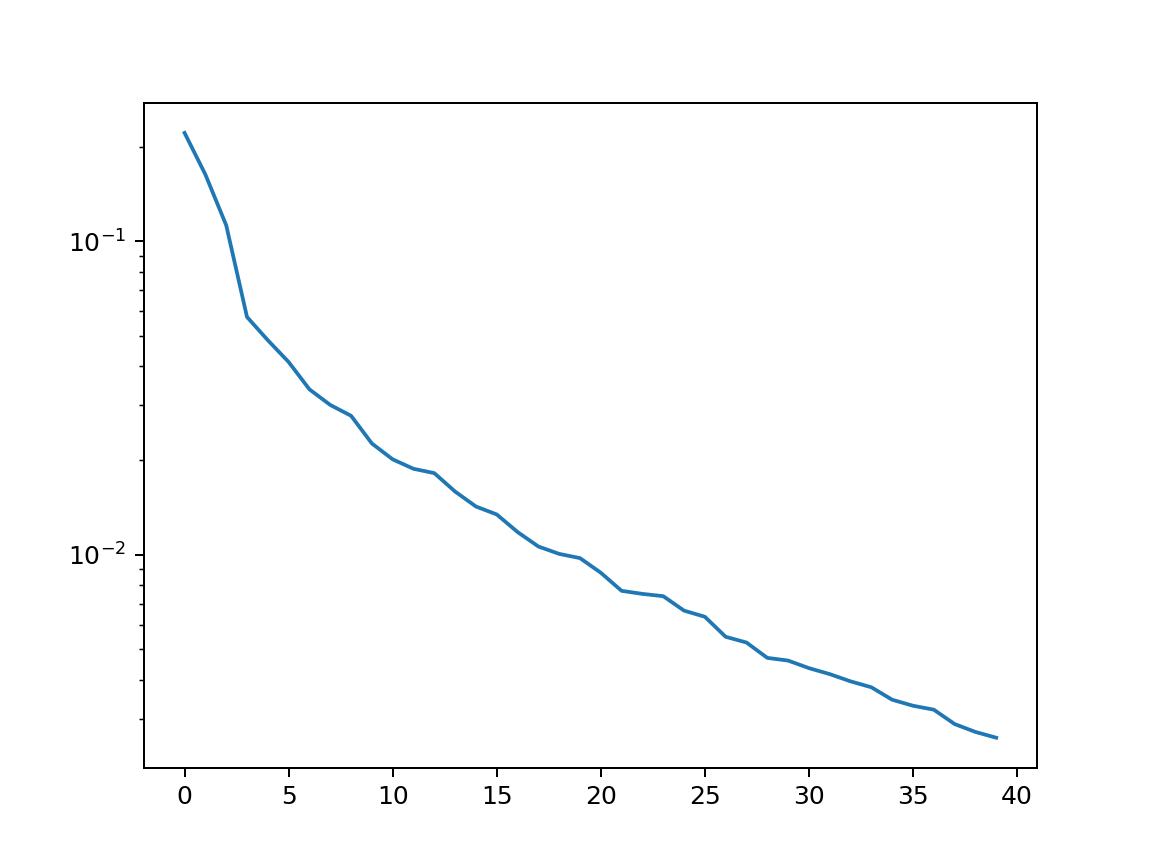

In [32]:
plt.figure()
plt.plot(EVR_nn)
plt.yscale('log')

In [33]:
features_nn.shape

torch.Size([9636, 768])

<IPython.core.display.Javascript object>


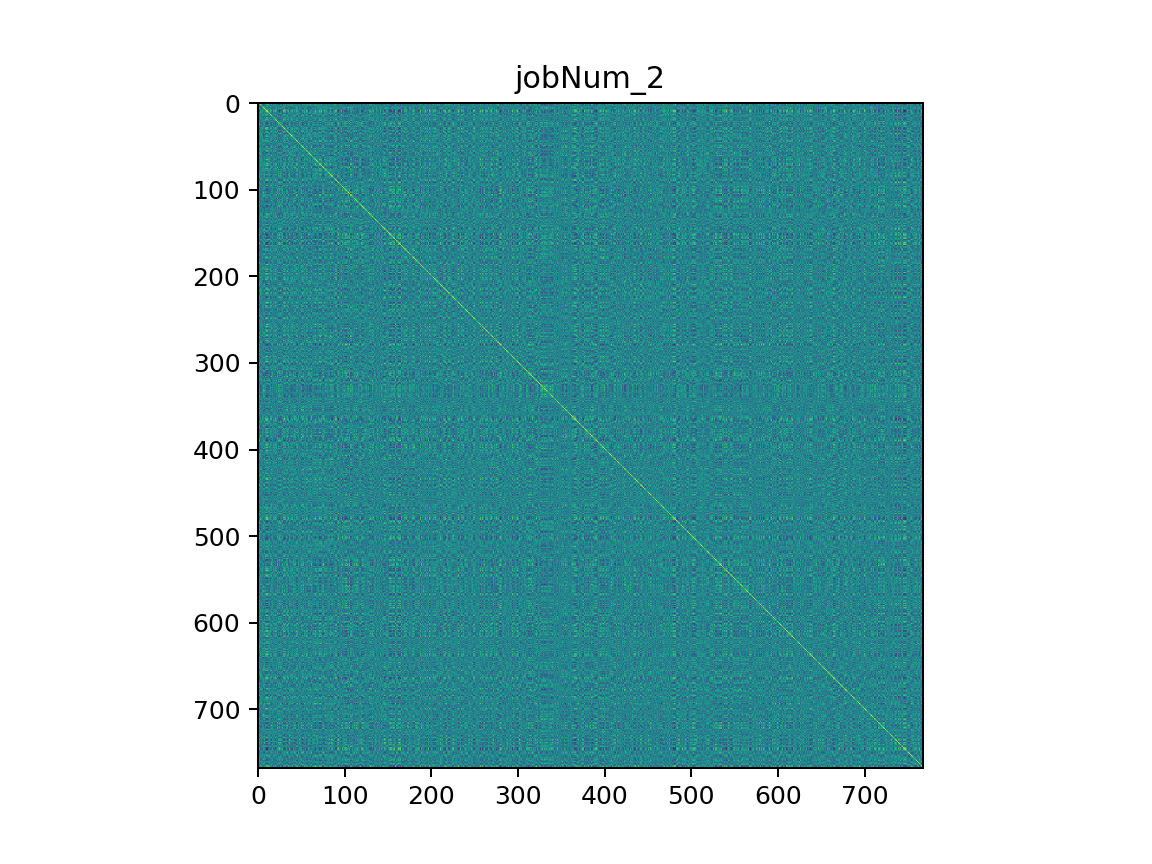

Text(0.5, 1.0, 'jobNum_2')

In [59]:
plt.figure()
plt.imshow(torch.corrcoef(features_nn.T))
plt.title(jn.split('/')[-1])

In [35]:
features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt]], dim=1)

In [36]:
features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(features_norm, labels_clean, test_size=0.3)
print(f'train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: {features_train.shape, features_val.shape, labels_train.shape, labels_val.shape}')

train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: (torch.Size([6745, 60]), torch.Size([2891, 60]), (6745,), (2891,))


In [37]:
acc_train, acc_val = [], []
C_toUse = np.array([1000, 100, 10,1,0.1,0.01,0.001])
# C_toUse = np.array([10**-4, 10**-5, 10**-6, 10**-7])
# C_toUse = np.array([10**2, 10**3, 10**4, 10**5])
for C in C_toUse:
    logreg = sklearn.linear_model.LogisticRegression(
        solver='lbfgs',
#         solve='sag'
#         solve='saga'
#         solver='newton-cg',
#         solver='liblinear',
        max_iter=6000, 
        C=C,
        fit_intercept=True, 
        class_weight='balanced',
    #     n_jobs=-1
    )
    logreg.fit(features_train, labels_train)

    acc = logreg.score(features_train, labels_train, sample_weight=get_balanced_sample_weights(labels_train))
    acc_train.append(acc)

    acc = logreg.score(features_val, labels_val, sample_weight=get_balanced_sample_weights(labels_val))
    acc_val.append(acc)
    
    

<IPython.core.display.Javascript object>


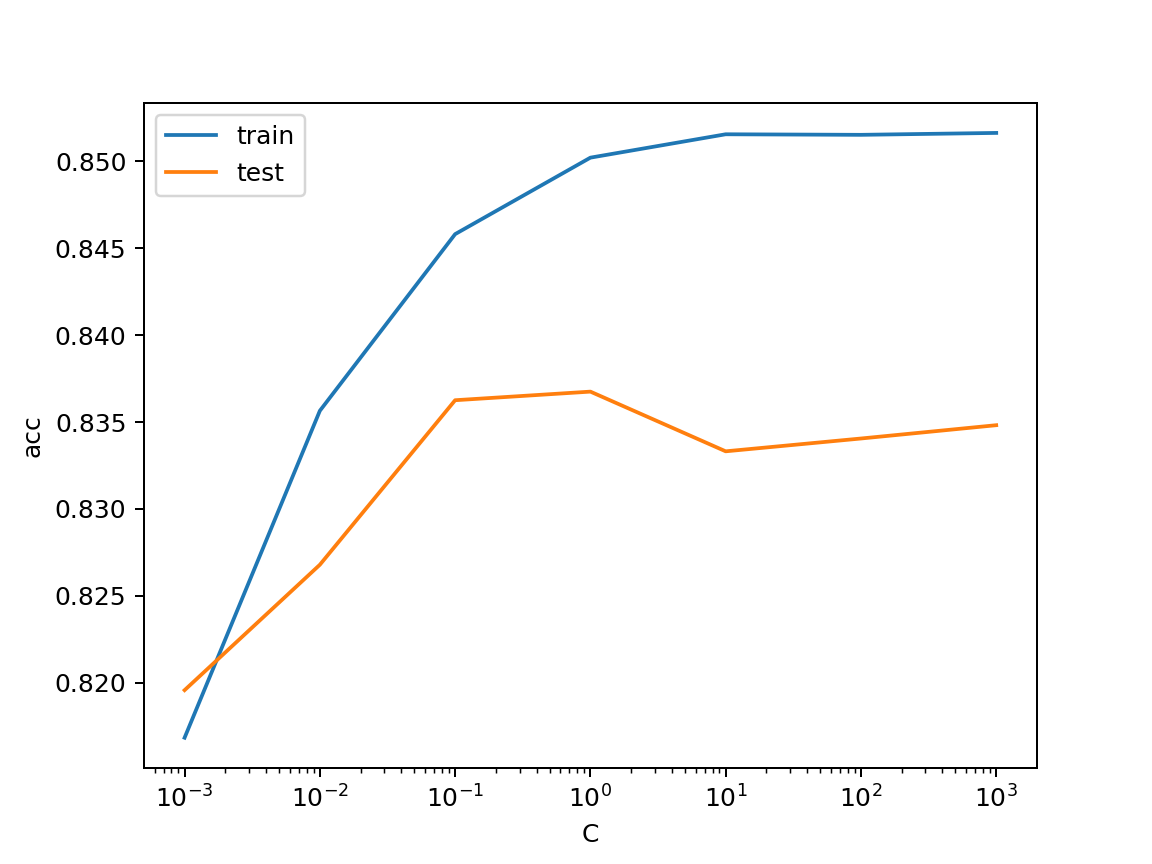

best val score: 0.8367478403546099
best C value: 1.0


In [38]:
plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

print(f'best val score: {max(acc_val)}')
print(f'best C value: {C_toUse[np.argmax(acc_val)]}')

In [39]:
logreg = sklearn.linear_model.LogisticRegression(
        solver='lbfgs',
#         solver='sag',
#         solver='saga',
#         solver='newton-cg',
#         solver='liblinear',
    max_iter=8000, 
    C=10**(0),
    fit_intercept=True, 
    class_weight='balanced',
#     n_jobs=-1
).fit(features_train, labels_train)

In [40]:
svm = sklearn.svm.SVC(
    C=10**(1), 
    kernel='rbf',
    degree=3, 
    gamma='scale',
    coef0=0.0, 
    shrinking=True,
    probability=False, 
    tol=0.001, 
    cache_size=200,
    class_weight='balanced',
    verbose=False, 
    max_iter=- 1, 
    decision_function_shape='ovr',
    break_ties=False,
    random_state=None
)
svm.fit(features_train, labels_train)

SVC(C=10, class_weight='balanced')

<IPython.core.display.Javascript object>


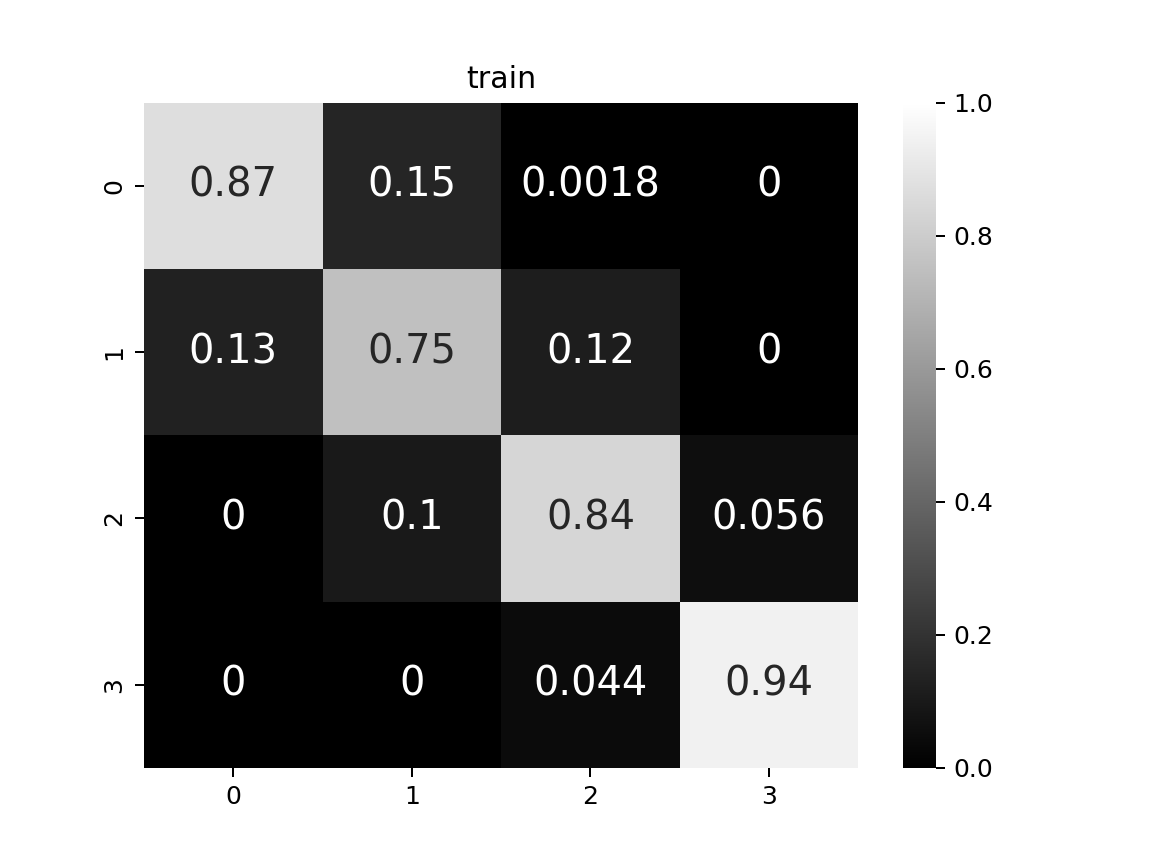

<IPython.core.display.Javascript object>


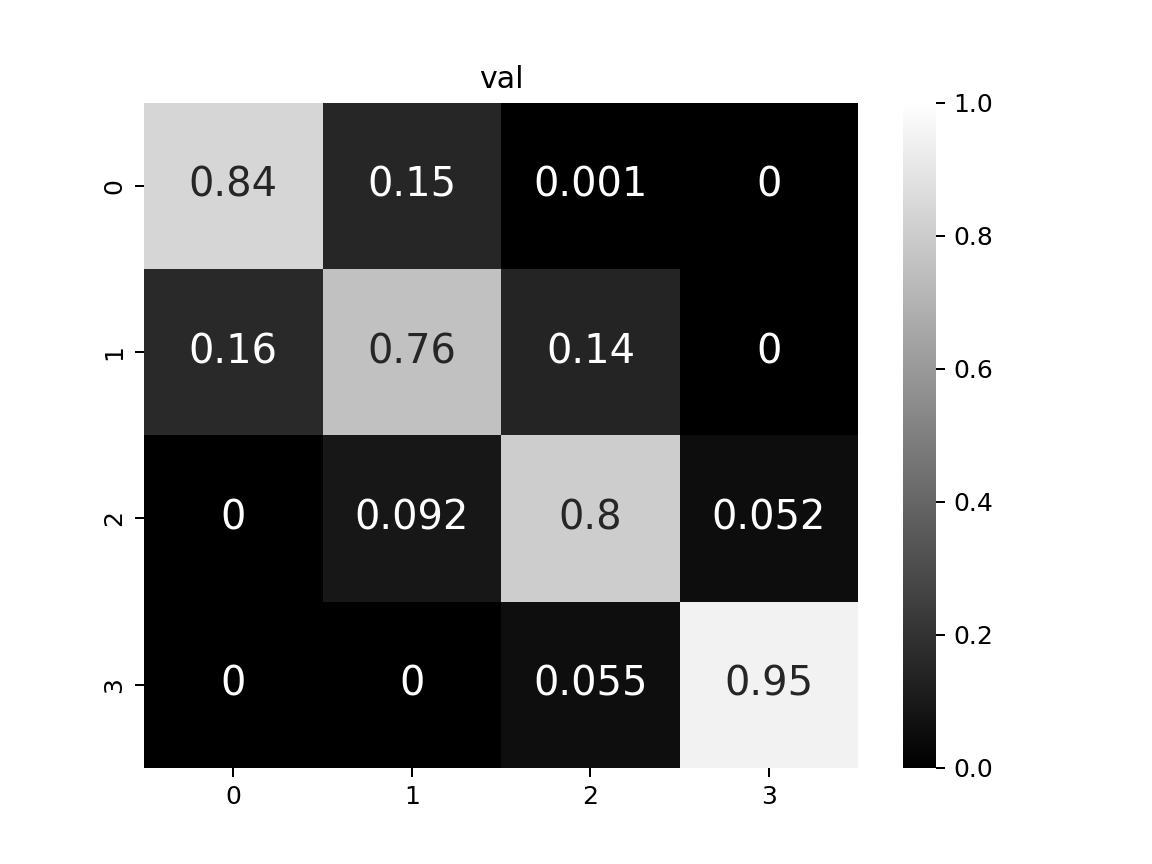

In [41]:
proba = logreg.predict_proba(features_train)
preds = np.argmax(proba, axis=1)

# preds = svm.predict(features_train_norm).astype(np.int32)

cm = classification.confusion_matrix(preds, labels_train.astype(np.int32))

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');

proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)

cm = classification.confusion_matrix(preds, labels_val.astype(np.int32))

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');

In [46]:
# labels_sesh1 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy')
# labels_sesh2 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh2.npy')

labels_sesh1 = np.load(path_labels[0])
labels_sesh2 = np.load(path_labels[1])

<IPython.core.display.Javascript object>


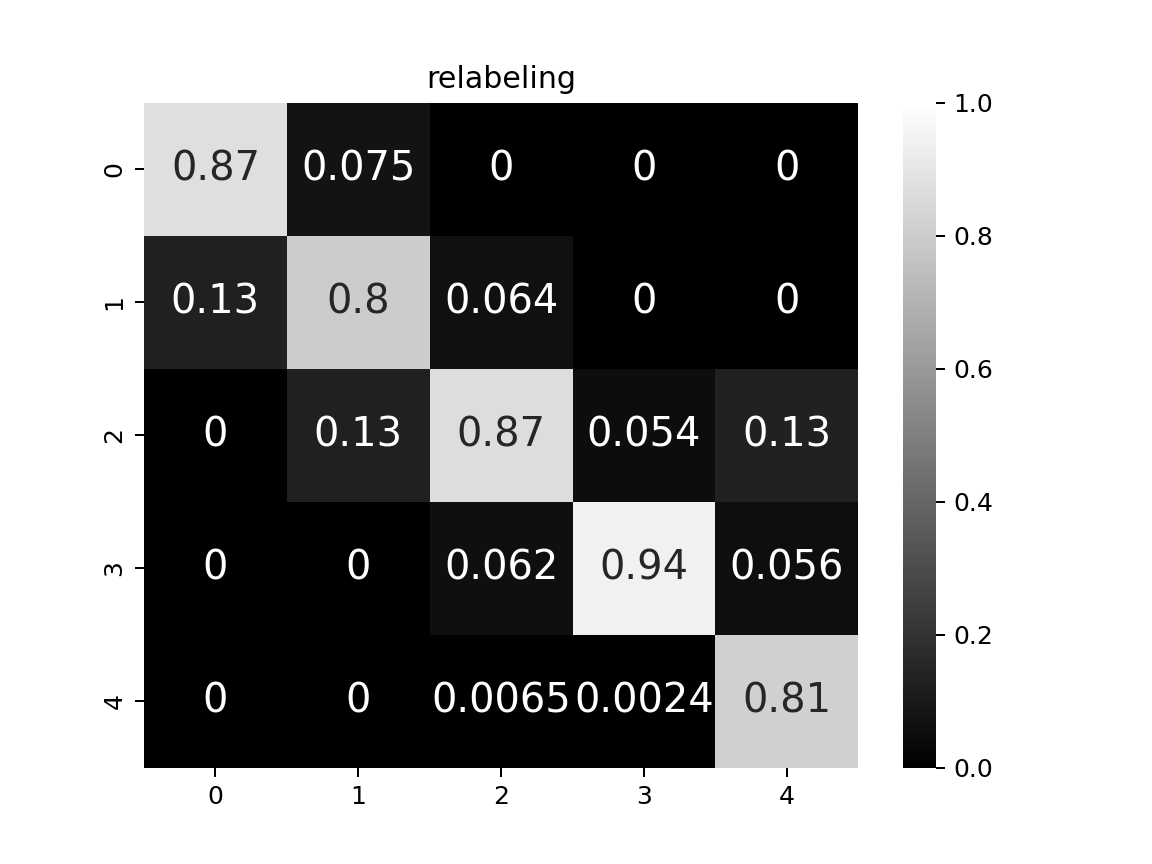

Text(0.5, 1.0, 'relabeling')

In [47]:
labels_sesh12cat = np.concatenate((labels_sesh1, labels_sesh2), axis=0)
labels_sesh21cat = np.concatenate((labels_sesh2, labels_sesh1), axis=0)
plt.figure()
sns.heatmap(
    classification.confusion_matrix(labels_sesh12cat.astype(np.int32), labels_sesh21cat.astype(np.int32)),
    annot=True, 
    annot_kws={"size": 16}, 
    vmax=1., 
    cmap=plt.get_cmap('gray')
)
plt.title('relabeling')

In [48]:
[(name, params.shape) for name, params in model.state_dict().items()]

[('base_model.0.0.0.0.weight', torch.Size([96, 3, 4, 4])),
 ('base_model.0.0.0.0.bias', torch.Size([96])),
 ('base_model.0.0.0.1.weight', torch.Size([96])),
 ('base_model.0.0.0.1.bias', torch.Size([96])),
 ('base_model.0.0.1.0.layer_scale', torch.Size([96, 1, 1])),
 ('base_model.0.0.1.0.block.0.weight', torch.Size([96, 1, 7, 7])),
 ('base_model.0.0.1.0.block.0.bias', torch.Size([96])),
 ('base_model.0.0.1.0.block.2.weight', torch.Size([96])),
 ('base_model.0.0.1.0.block.2.bias', torch.Size([96])),
 ('base_model.0.0.1.0.block.3.weight', torch.Size([384, 96])),
 ('base_model.0.0.1.0.block.3.bias', torch.Size([384])),
 ('base_model.0.0.1.0.block.5.weight', torch.Size([96, 384])),
 ('base_model.0.0.1.0.block.5.bias', torch.Size([96])),
 ('base_model.0.0.1.1.layer_scale', torch.Size([96, 1, 1])),
 ('base_model.0.0.1.1.block.0.weight', torch.Size([96, 1, 7, 7])),
 ('base_model.0.0.1.1.block.0.bias', torch.Size([96])),
 ('base_model.0.0.1.1.block.2.weight', torch.Size([96])),
 ('base_model.0.

<IPython.core.display.Javascript object>


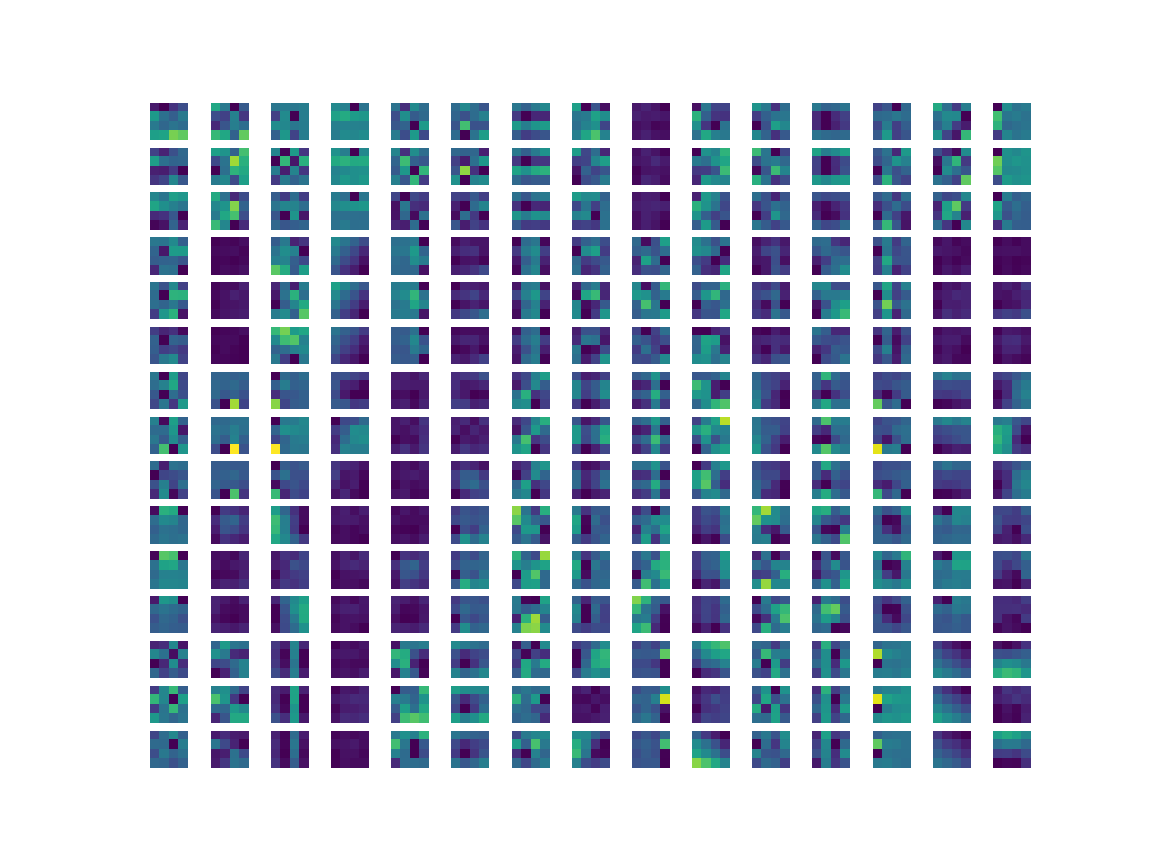

In [53]:
layer_1 = model.state_dict()['base_model.0.0.0.0.weight'].cpu()

# layer_1 = model.state_dict()['base_model.0.0.0.weight'].cpu()
# layer_2 = model.state_dict()['base_model.0.6.3.block.1.0.weight'].cpu()
# layer_3 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()
# layer_4 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()


plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_1], dim=0), grid_shape=(15,15), kwargs_imshow={'vmax': 0.2});
# plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_2], dim=0), grid_shape=(6,6), kwargs_imshow={'vmax': 0.2});
# plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_3], dim=0), grid_shape=(4,6), kwargs_imshow={'vmax': 0.2});

In [54]:
umap = UMAP(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

In [55]:
embeddings = umap.fit_transform(features_nn)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<IPython.core.display.Javascript object>


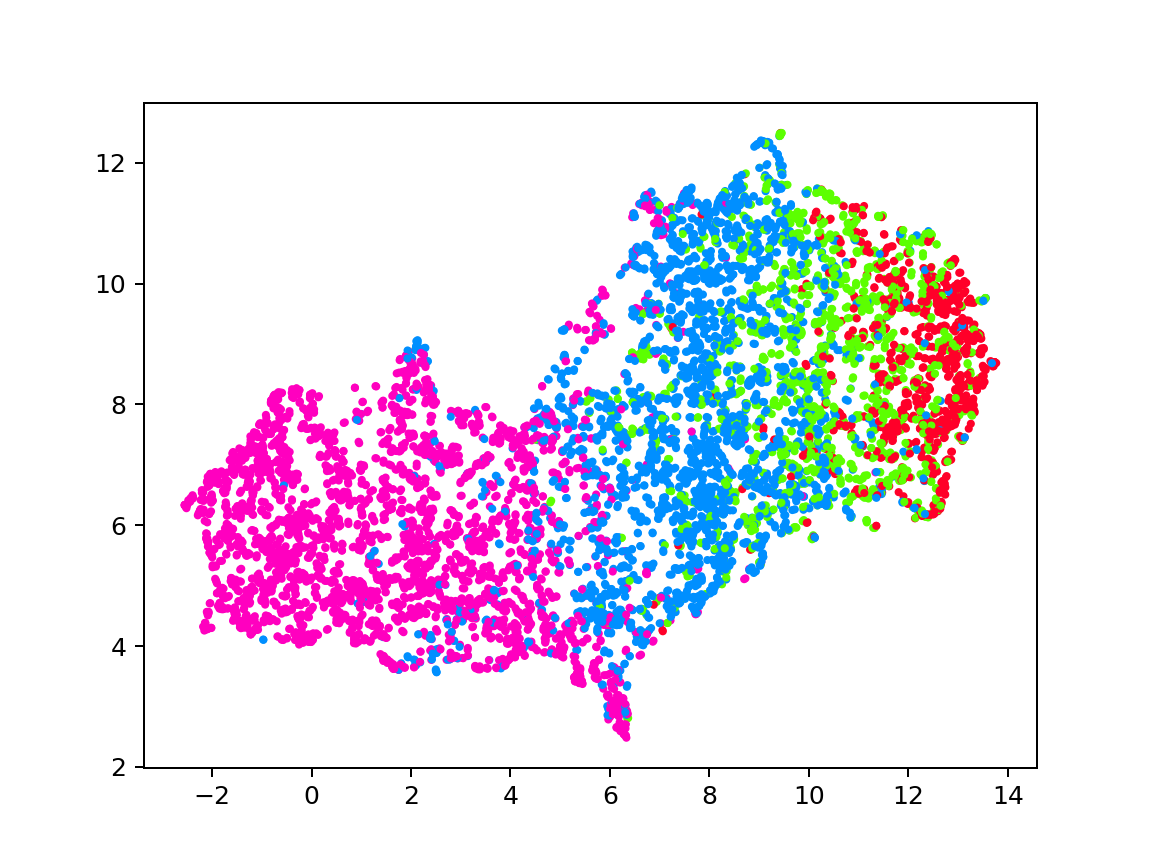

In [56]:
plt.figure()
plt.scatter(embeddings[:,0], embeddings[:,1], s=5, c=labels_clean, cmap='gist_rainbow')

<IPython.core.display.Javascript object>


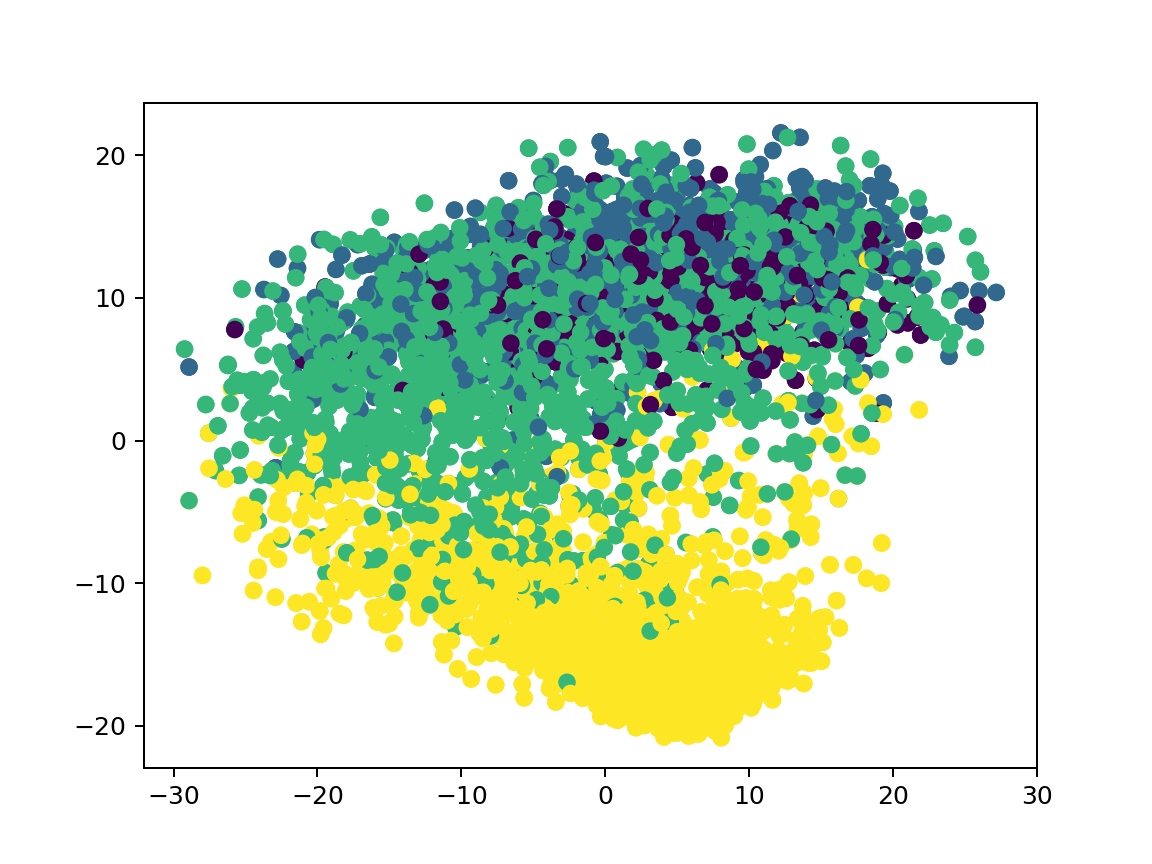

In [57]:
plt.figure()
plt.scatter(scores_nn[:,1], scores_nn[:,0], c=labels_clean)